In [1]:
# experiment.ipynb
# setting up
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In this notebook, we'll aim to make it possible to run the Mesa version of the ElectricityMarket model, but to then get outputs matching those in the source notebook.

So, to outline:

0. Get the model ready by feeding in params from our source notebook.
1. Run the model (with any quality of life paramaterization inputs) from the first cell.
2. Take the model outputs (which also could be accessed through the Mesa framework)
3. Convert the mesa outputs to the vectors from the source notebook.
4. Plot just as before.

We will structure *this* notebook to mirror the source as best we can. ⚡️

In [2]:
from mesa import Model # noqa
from model import ElectricityMarket # noqa

Okay! Mesa! Before we get rolling with parameters, let's talk about what we're going to do with the logic from the original notebook. To understand the plan, it's important to know about the Mesa Framework that it supplies a couple of key basic tools we can use: the [Model](https://mesa.readthedocs.io/latest/apis/model.html#module-mesa.model) class, and the [Agent](https://mesa.readthedocs.io/latest/apis/agent.html) class. The model is where we'll need to register and step through many of the equations of the notebook, while the agent objects will take the basic decisioning logic that executes each step.

In the following code cell, we have a *synopsis* of the major functions from the model code in the `ElectricityAuctions` notebook. Uncommenting the cell may interfere with running this notebook.

In [3]:
pass

"""The logic from this block can ALL be found in the `model.py` file..

define functions
def find_capacities(prices, m, b):
    return m * prices + b

def create_expectations(n, capacities, costs):
    # logic here
    return(capacity_expectations, cost_expectations, expected_rankings)
    
def auction(N, bids, capacities):
    # complicated logic here
    return(quantities, last_price)

def outcomes(mechanism, last_price, bids, quantities, costs):
    if mechanism == 'uniform':
        revenues = last_price * quantities  
    else:
        revenues = bids * quantities
    profits = revenues - costs * quantities
    return(revenues, profits)

## The logic from this block can ALL be found in the `agents.py` file.

def generate_bids(n, N, mechanism, capacity_expectations, cost_expectations, expected_rankings, padding, costs):
    bids = np.empty(n)
    for g in range(n):    
       # complicated logic here
    return(bids)

###########################

## and then we have these critical equations:
costs = rng.uniform(min_cost, max_cost, n)
capacities = find_capacities(costs, m, b)
price_cap = max(costs) * cap_multiplier
errors = (rng.uniform(min_error, max_error, n*n) / 100 * np.random.choice([-1,1],size=n*n)).reshape([n,n])
padding = rng.uniform(min_padding, max_padding, n) / 100
capacity_expectations, cost_expectations, expected_rankings = create_expectations(n, capacities, costs)

these are in the `model.py` file.


"""


"The logic from this block can ALL be found in the `model.py` file..\n\ndefine functions\ndef find_capacities(prices, m, b):\n    return m * prices + b\n\ndef create_expectations(n, capacities, costs):\n    # logic here\n    return(capacity_expectations, cost_expectations, expected_rankings)\n    \ndef auction(N, bids, capacities):\n    # complicated logic here\n    return(quantities, last_price)\n\ndef outcomes(mechanism, last_price, bids, quantities, costs):\n    if mechanism == 'uniform':\n        revenues = last_price * quantities  \n    else:\n        revenues = bids * quantities\n    profits = revenues - costs * quantities\n    return(revenues, profits)\n\n## The logic from this block can ALL be found in the `agents.py` file.\n\ndef generate_bids(n, N, mechanism, capacity_expectations, cost_expectations, expected_rankings, padding, costs):\n    bids = np.empty(n)\n    for g in range(n):    \n       # complicated logic here\n    return(bids)\n\n###########################\n\n## an

One important point: there is overlap between how the code from the source notebook executes and the standard functions of the Mesa model and agents objects. Wherever practical, we will stick to using the functionality provided in the source. One key difference is that our time and step-running logic will be delegated to Mesa fundamental functions.

⚡️

Let's first get ready by setting up a set of parameters to pass our Mesa Model. The Mesa Model object, among other things, natively takes keyword-arguments (or kwargs) at initialization time. But, of course, it can also have defaults. This means that we can set some parameters or all parameters in the cell below, and they will be passed to the underlying Mesa engine.

Once we're done readying parameters, we can run the cell. `ElectricityMarket.run` will pass the parameters to the model in `model.py`, and it will run its steps. 1000 steps can take a few seconds!

In [4]:
# set parameters
n = 5
m = -5
b = 1000
steps = 1000
min_cost = 20
max_cost = 200
min_error = 1
max_error = 20
min_padding = 50
max_padding = 99
cap_multiplier = 1.2

params = {
    'n': n,
    'm': m,
    'b': b,
    'steps': steps,
    'min_cost': min_cost,
    'max_cost': max_cost,
    'min_error': min_error,
    'max_error': max_error,
    'min_padding': min_padding,
    'max_padding': max_padding,
    'cap_multiplier': cap_multiplier
}

model = ElectricityMarket(**params) # this is our Mesa Model! We'll run it in a sec.

# or, you can run the model with one param:
# steps = 88888
# model = ElectricityMarket.run(steps=steps)

# or, you can just run the model with the defaults:
# returns = ElectricityMarket.run()

Okay, our model is set up. We are almost ready to run... but first, to integrate with the rest of the Mesa setup, we will replace this approach
from the source model:

```py
mechanism = 'uniform'
#mechanism = 'discriminatory'
#mechanism = 'ownbid'
```

... with an array that allows us to run the model once for each mechanism:

In [5]:
mechanisms = ['uniform', 'discriminatory', 'ownbid']

# note that steps and agents(n) are defined... but they may have been commented out above. 
# let's make sure we have them
steps = steps if 'steps' in locals() else 1000
n = n if 'n' in locals() else 5

# the following code is almost straight from the source notebook,
# but we modify it to work with each mechanism in the array.
# # initialise arrays to store simulation results for each time step.
RTO_costs_by_mechanism = {mechanism: np.empty(steps) for mechanism in mechanisms} # note that steps
GenCo_profits_by_mechanism = {mechanism: np.empty([steps,n]) for mechanism in mechanisms} # and number of agents are defined in params

Okay, great. Now we are ready to run the model. The original code block from the notebook looks like:

```py
# for timesteps specified by steps, run a series of auctions. 
# each time step the RTO request varies.
for s in range(steps): 
    N = rng.uniform(int(np.mean(capacities)), int(np.sum(capacities)))
    bids = generate_bids(n, N, mechanism, capacity_expectations, cost_expectations, expected_rankings, padding, costs)
    quantities, last_price = auction(N, bids, capacities)
    revenues, profits = outcomes(mechanism, last_price, bids, quantities, costs)
    RTO_costs[s] = sum(revenues)
    GenCo_profits[s] = profits
```

This logic will go into the `model.py` code's `_run_model()_` method of the `ElectricityMarket` class extending the Mesa `Model`.
So, we need only run the model, although we will wrap it in a loop so that we can get returns for each of our mechanisms.

In [6]:
# the definition for our ElectricityMarket model specifies a return of:
# {
#     'RTO_costs': Array of RTO costs for each step
#     'GenCo_profits': 2D array of profits for each GenCo at each step
#     'mechanism': Mechanism used for this run
# }


for mechanism in mechanisms:
    model.mechanism = mechanism
    results = model.run_model(mechanism)

    # now we can move those results into our vectors, very similarly to the source notebook.

    RTO_costs_by_mechanism[mechanism] = results['RTO_costs']
    GenCo_profits_by_mechanism[mechanism] = results['GenCo_profits']

    # and we might like to make a gesture to our audience:
    print(f"Mechanism {mechanism} complete.")
    print(f"Mean RTO cost: {round(np.mean(RTO_costs_by_mechanism[mechanism]), 2)}")
    print(f"Mean GenCo profit: {round(np.mean(np.sum(GenCo_profits_by_mechanism[mechanism], axis=1)), 2)}")

    # create a fresh model instance for the next mechanism
    model = ElectricityMarket(**params)



Time: 0
Time: 100
Time: 200
Time: 300
Time: 400
Time: 500
Time: 600
Time: 700
Time: 800
Time: 900
Mechanism uniform complete.
Mean RTO cost: 169769.69
Mean GenCo profit: 99412.25
Time: 0
Time: 100
Time: 200
Time: 300
Time: 400
Time: 500
Time: 600
Time: 700
Time: 800
Time: 900
Mechanism discriminatory complete.
Mean RTO cost: 222066.25
Mean GenCo profit: 118641.08
Time: 0
Time: 100
Time: 200
Time: 300
Time: 400
Time: 500
Time: 600
Time: 700
Time: 800
Time: 900
Mechanism ownbid complete.
Mean RTO cost: 93504.2
Mean GenCo profit: 0.0


Hopefully, that printed a nice list of pretty statistics. Now, looking back at our agenda, we are more or less through the entire stage of setting up
our vectors. We are almost ready to plot.

⚡️

Before we do that, let's try a little bit of a detour, since we should have arrays for all three mechanisms. We can add some interactivity
to our plotting, by introducing some dropdowns... These simple controls are python notebook widgets (`ipywidgets`) and they should work,
when installed, in many environments. Let's see how this works!

In [13]:
mechanism_one_dropdown = widgets.Dropdown(
    options=mechanisms,
    value='uniform',
    description='Mechanism 1:',
    style={'description_width': 'initial'}
)

mechanism_two_dropdown = widgets.Dropdown(
    options=mechanisms,
    value='discriminatory',
    description='Mechanism 2:',
    style={'description_width': 'initial'}
)

display(widgets.VBox([mechanism_one_dropdown, mechanism_two_dropdown]))

You should see the dropdowns above so that you can choose a mechanism to compare to some other mechanism in the plots delow. We have defaults, so it's not a huge deal if you
can't get the controls to work in your notebook.

In [14]:
selected_mechanism_one = mechanism_one_dropdown.value if mechanism_one_dropdown.value is not None else 'uniform'
selected_mechanism_two = mechanism_two_dropdown.value if mechanism_two_dropdown.value is not None else 'discriminatory'

print(f"selected_mechanism_one: {selected_mechanism_one}")
print(f"selected_mechanism_two: {selected_mechanism_two}")

mean_cost_mechanism_one = np.mean(RTO_costs_by_mechanism[selected_mechanism_one])
mean_cost_mechanism_two = np.mean(RTO_costs_by_mechanism[selected_mechanism_two])

mean_profit_mechanism_one = np.mean(np.sum(GenCo_profits_by_mechanism[selected_mechanism_one], axis=1))
mean_profit_mechanism_two = np.mean(np.sum(GenCo_profits_by_mechanism[selected_mechanism_two], axis=1))


selected_mechanism_one: uniform
selected_mechanism_two: discriminatory


And now let's go ahead and build out plots, with just a subtle tweak to handle the names from above.

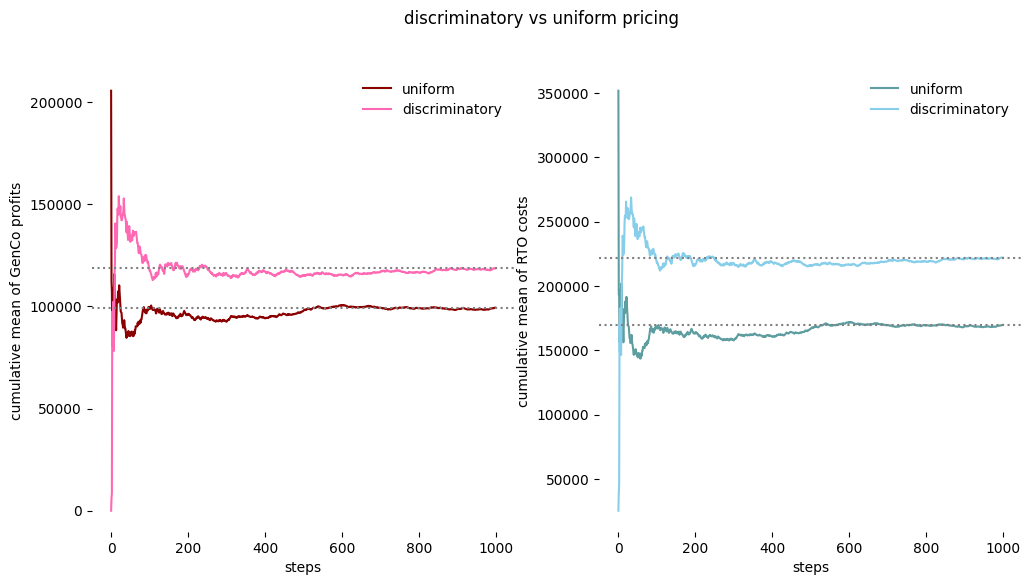

In [15]:

# plot profit and cost values for the various auction price mechanisms
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 6))

ax[0].plot(range(steps), np.cumsum(np.sum(GenCo_profits_by_mechanism[selected_mechanism_one], axis=1)) / np.arange(1, steps + 1), c = 'darkred', label = selected_mechanism_one)
ax[0].plot(np.cumsum(np.sum(GenCo_profits_by_mechanism[selected_mechanism_two], axis=1)) / np.arange(1, steps + 1), c = 'hotpink', label = selected_mechanism_two)
ax[0].set_xlabel('steps')
ax[0].set_ylabel('cumulative mean of GenCo profits')
ax[0].legend(frameon = False)
ax[1].plot(range(steps), np.cumsum(RTO_costs_by_mechanism[selected_mechanism_one]) / np.arange(1, steps + 1), c = 'cadetblue', label = selected_mechanism_one)
ax[1].plot(np.cumsum(RTO_costs_by_mechanism[selected_mechanism_two]) / np.arange(1, steps + 1), c = 'skyblue', label = selected_mechanism_two)
ax[1].set_xlabel('steps')
ax[1].set_ylabel('cumulative mean of RTO costs')
ax[1].legend(frameon = False)

#ax[0].annotate('uniform', xy=(600, 63000))
#ax[0].annotate('discriminatory', xy=(600, 50500))
#ax[1].annotate('uniform', xy=(700, 160000))
#ax[1].annotate('discriminatory', xy=(700, 148000))
ax[1].axhline(y = mean_cost_mechanism_one, linestyle = 'dotted', c = 'grey')
ax[1].axhline(y = mean_cost_mechanism_two, linestyle = 'dotted', c = 'grey')
ax[0].axhline(y = mean_profit_mechanism_one, linestyle = 'dotted', c = 'grey')
ax[0].axhline(y = mean_profit_mechanism_two, linestyle = 'dotted', c = 'grey')

fig.suptitle('discriminatory vs uniform pricing')
sns.despine(left = True, bottom = True)